Link to lesson: https://carpentries-incubator.github.io/SDC-BIDS-fMRI/07-functional-connectivity-analysis/index.html

# Using Nilearn’s High-level functionality to compute correlation matrices

In [1]:
import os
from nilearn import signal as sgl
from nilearn import image as img
from nilearn import plotting as plot
from nilearn import datasets
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bids
%matplotlib inline


/home/share/git/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
bids.config.set_option('extension_initial_dot', True)
layout = bids.layout.BIDSLayout(fmriprep_dir, validate=False)
subjects = layout.get_subjects()

In [3]:
#Load separated parcellation
parcel_file = '../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz'
yeo_7 = img.load_img(parcel_file)

In [4]:
from nilearn import input_data
masker = input_data.NiftiLabelsMasker(labels_img=yeo_7,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      verbose=1,
                                      detrend=True,
                                     low_pass = 0.08,
                                     high_pass = 0.009,
                                     t_r=2)

In [5]:
pooled_subjects = []
ctrl_subjects = []
schz_subjects = []
tr_drop = 4

for sub in subjects:

    func_file = layout.get(subject = sub, datatype = 'func', suffix='preproc', return_type = 'file' )[0]
    confound_file = layout.get(subject = sub, datatype = 'func', suffix='confounds', return_type = 'file' )[0]

    #Load functional file and perform TR drop
    func_img = img.load_img(func_file)
    func_img = func_img.slicer[:,:,:,tr_drop+1:]

    #Convert confounds file into required format
    confound_df = pd.read_csv(confound_file, delimiter='\t')


    confound_vars = ['X','Y','Z','RotX','RotY','RotZ','GlobalSignal','aCompCor01','aCompCor02']
    confound_df = confound_df[confound_vars]


    #Drop TR on confound matrix
    confounds = confound_df.loc[tr_drop+1:]

    #Apply cleaning, parcellation and extraction to functional data
    time_series = masker.fit_transform(func_img,confounds)
    time_series.shape
    
    if sub.startswith('1'):
        ctrl_subjects.append(time_series)
    if sub.startswith('5'):
        schz_subjects.append(time_series)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
Resampling labels
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f1a75ab6970>, <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7f1a747bcfd0>, 
{ 'background_label': 0,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.009,
  'high_variance_confounds': False,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7f1a747e3220>,
  'low_pass': 0.08,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': 2,
  'target_affine': None,
  '

/home/share/git/scwg2018_python_neuroimaging/scwg2018_nilearn/lib/python3.8/site-packages/nilearn/input_data/nifti_labels_masker.py:320: UserWarning: Persisting input arguments took 0.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(


_______________________________________________filter_and_extract - 1.5s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transfor

In [6]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')

ctrl_correlation_matrices = correlation_measure.fit_transform(ctrl_subjects)
schz_correlation_matrices = correlation_measure.fit_transform(schz_subjects)


In [7]:
def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plot.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

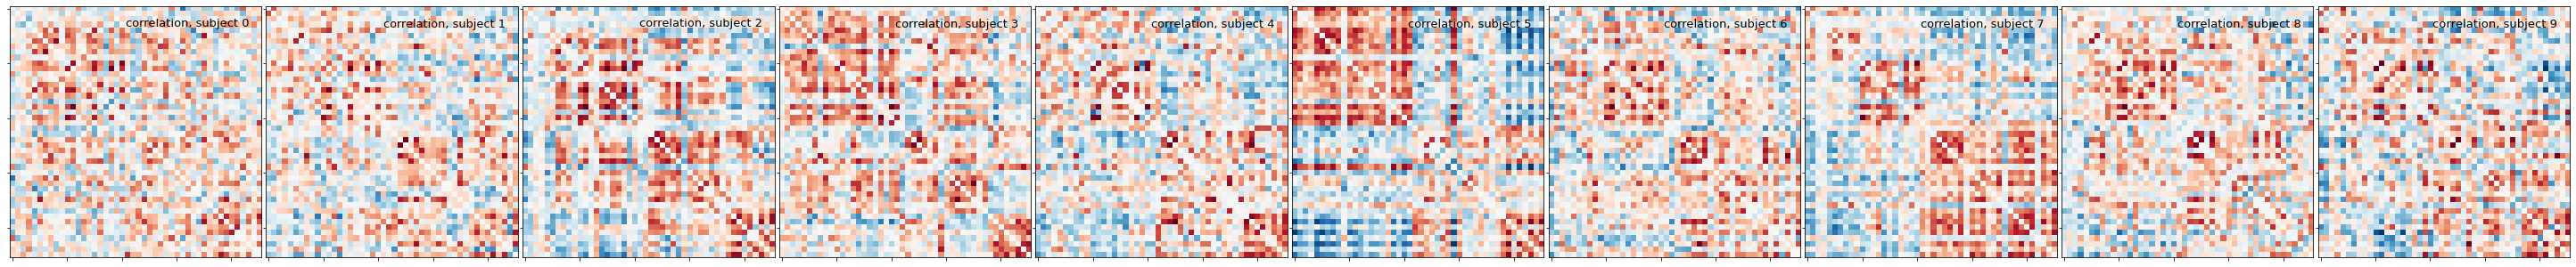

In [8]:
plot_matrices(ctrl_correlation_matrices, 'correlation')

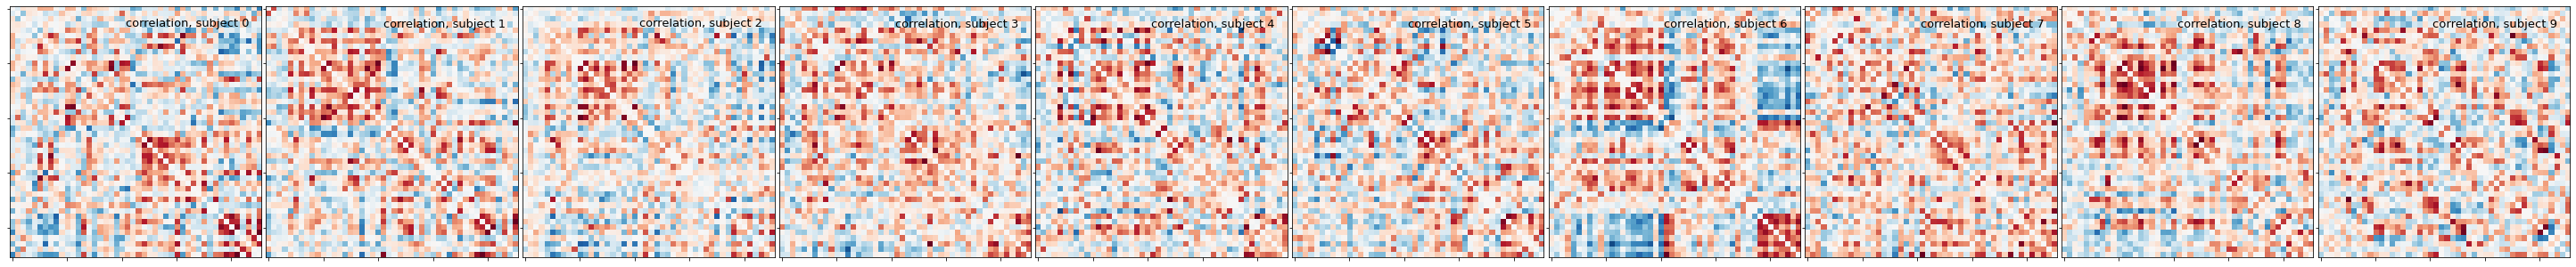

In [9]:
plot_matrices(schz_correlation_matrices, 'correlation')

In [10]:
ctrl_correlation_matrices.shape

(10, 46, 46)

In [11]:
ctrl_roi_vec = ctrl_correlation_matrices[:,43,45]
schz_roi_vec = schz_correlation_matrices[:,43,45]

import seaborn as sns

#Create dataframes so we can visualize in seaborn
ctrl_df = pd.DataFrame(data={'dmn_corr':ctrl_roi_vec, 'group':'control'})
scz_df = pd.DataFrame(data={'dmn_corr':schz_roi_vec, 'group' : 'schizophrenia'})

#Stack dataframes
df = pd.concat([ctrl_df, scz_df], ignore_index=True)

#Pick 5 random people to display
df.sample(n=5)

,dmn_corr,group
9,0.431855,control
0,0.432300,control
5,0.639375,control
1,0.560255,control
8,0.094141,control


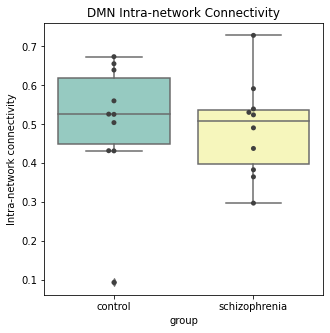

In [12]:
#Visualize results
plot = plt.figure(figsize=(5,5))
ax = sns.boxplot(x='group',y='dmn_corr',data=df,palette='Set3')
ax = sns.swarmplot(x='group',y='dmn_corr',data=df,color='0.25')
ax.set_title('DMN Intra-network Connectivity')
ax.set_ylabel(r'Intra-network connectivity')
plt.show()
